# Stanford CME 241 (Winter 2024) - Assignment 5

**Due: Feb 12 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Solve any 3 of the 4 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/neelsnarayan/cme241/blob/master/neel_mehdi_assignments/assignment5/Neel_Mehdi_Assignment5.ipynb

*Group members (replace below names with people in your group):* 
- Neel Narayan
- Mehdi Zhioua

## Imports

In [19]:
%load_ext autoreload
%autoreload 2
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
sys.path.append('../../rl/chapter9')
from rl.distribution import Categorical
from typing import Callable, Dict, Iterable, Generic, Sequence, Tuple, Mapping, TypeVar, Set, List
from matplotlib.ticker import MaxNLocator
from markov_process import State, MarkovProcess, NonTerminal, Terminal
from rl.markov_decision_process import MarkovDecisionProcess
from rl.distribution import SampledDistribution
from rl.function_approx import FunctionApprox
from rl.function_approx import DNNSpec, AdamGradient, DNNApprox
from rl.approximate_dynamic_programming import back_opt_qvf
from order_book import OrderBook, DollarsAndShares, PriceSizePairs
from numpy.random import poisson
from dataclasses import dataclass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Question 1
You are a milkvendor and your task is to bring to your store a supply
(denoted $S \in \mathbb{R}$) of milk volume in the morning that will
give you the best profits. You know that the demand for milk through the
course of the day is a probability distribution function $f$ (for
mathematical convenience, assume people can buy milk in volumes that are
real numbers, hence milk demand $x \in \mathbb{R}$ is a continuous
variable with a probability density function). For every extra gallon of
milk you carry at the end of the day (supply $S$ exceeds random demand
$x$), you incur a cost of $h$ (effectively the wasteful purchases
amounting to the difference between your purchase price and end-of-day
discount disposal price since you are not allowed to sell the same milk
the next day). For every gallon of milk that a customer demands that you
don't carry (random demand $x$ exceeds supply $S$), you incur a cost of
$p$ (effectively the missed sales revenue amounting to the difference
between your sales price and purchase price). So your task is to
identify the optimal supply $S$ that minimizes your Expected Cost
$g(S)$, given by the following:

$$g_1(S) = E[\max(x-S, 0)] = \int_{-\infty}^{\infty} \max(x-S, 0) \cdot f(x) \cdot dx = \int_S^{\infty} (x-S) \cdot f(x) \cdot dx$$
$$g_2(S) = E[\max(S-x, 0)] = \int_{-\infty}^{\infty} \max(S-x, 0) \cdot f(x) \cdot dx = \int_{-\infty}^S (S-x) \cdot f(x) \cdot dx$$

$$g(S) = p \cdot g_1(S) + h \cdot g_2(S)$$

After you solve this problem, see if you can frame this problem in terms
of a call/put options portfolio problem.

Assuming the necessary regularity conditions on $f$, we can solve this optimization problem by finding a first order condition :
$$
p\frac{\partial g_1}{\partial S} + h \frac{\partial g_2}{\partial S} = 0
$$
$$
p\int_{-\infty}^{\infty} -\mathbb{1}_{x>S} f(x) dx + h \int_{-\infty}^{\infty} \mathbb{1}_{S>x} f(x) dx = 0
$$
$$
h \int_{—\infty}^S f(x)dx = p \int_{S}^{+\infty} f(x)dx 
$$
Naming $F(x):=\int_{-\infty}^xf(x) dx$ the cumulative density of the distribution $f$, we get:
$$
h F(S) = p (1-F(S))
$$
$$
F(S) = \frac{p}{h+p}
$$
And therefore we get the optimal value :
$$
S^* = F^{-1}\left(\frac{p}{h+p}\right)
$$
Where $F^{-1}$ is the inverse cumulative distribution function. This problem can naturally be framed in terms of call/put options portfolio problem because
$$
g_1(S) = Put(x,S) 
$$
Which is the price of an european put option on underlying $x$ with strike $S$, and
$$
g_2(S) = Call(x,S) 
$$
Which is the price of an european call option on underlying $x$ with strike $S$. Therefore, from the dealer's persepctive the portflio optimization problem consists in selecting the strike $S$ that will minimize the payoff that the dealer will have to pay on a portfolio of $p$ Puts and $h$ calls

## Question 2
[rl/chapter8/optimal_bin_tree.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter8/optimal_exercise_bin_tree.py)
models the American Payoff pricing problem as a `FiniteMarkovDecisionProcess` in the form of a binary tree with only two
discrete transitions for any given asset price. In the world of mathematical and computational finance, it is common practice to work
with continuous-valued asset prices and transitions to a continuous set of asset prices for the next time step. Your task is to model this
problem as a `MarkovDecisionProcess` (not finite) with discrete time, continuous-valued asset prices and a continuous-set of transitions.
Assume an arbitrary probability distribution for asset price movements from one time step to another, so you'd be sampling from the arbitrary
transition probability distribution. Hence, you will be solving this problem with Approximate Dynamic Programming using the code in
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py).

Our goal here is to find the optimal time to exercise an american option. Therefore, we will consider the state of actions 0/1 describing wether we execute the option or not. We want to use the `back_opt_qvf` function from the `approximate_dynamic_programming.py` codebase. Therefore, we need to have our price process represented in an `Sequence[MDP_FuncApprocV_Distribution[S,A]]`, structure, with each time step represented as its own MDP. We therefore have to specify our implementation in the following order : 
1. represent an MDP representing a single time step with a .step() method
2. When sampling the new state, we specify that we want the price dynamic (we adopt a classical GBM)

$$
dS/S = \sigma dW
$$
$$
S_{t+1} = S_t(1+ \sigma dW)
$$

In [31]:
def sample_next_price(
        price,
        dt,
        sigma
    ):
    """
    Function implementing the GBM dynamic - Can be replaced by any other SDE
    """
    sigmadW = np.sqrt(sigma)*np.sqrt(dt)*np.random.normal()
    next_price = price*(1+sigmadW)
    return next_price

3. Now that we have specified an SDE modeling our price process, we can code up the `AmericanOption` class. Following the spirit of the dynamic asset allocation problem. This class will construct the `mdf_f0_mu_triples`object as described in the book, instanciating an MDP for each decision of wether we execute the option or not. 

In [90]:
class AmericanOption:

    def __init__(self,strike, spot , payoff, vol, dnn_spec, feature_functions, T=1,n=100):
        """
        payoff(K,S)
        """
        self.spot  = spot
        self.strike = strike 
        self.payoff = payoff
        self.vol = vol
        self.T = T
        self.n = n
        self.dt = T/n
        self.dnn_spec = dnn_spec
        self.feature_functions = feature_functions

    class ExerciseDecision(MarkovDecisionProcess[float,int]):
        """
        At each time step, we model the exercise decision as a MDP
        """

        def __init__(self,K,payoff,vol,dt):
            self.K = K
            self.payoff = payoff
            self.vol = vol
            self.dt = dt

        def step(self, state: NonTerminal[float],exercise: int):
                def sample_next(state=state) ->  Tuple[State[float], float]:
                    """
                    Function to sample next (state , reward)
                    The reward here is simply the value of the payoff we can obtain using the option's contract  (payoff(K,S)) and the next state
                    is going to be terminal or non terminal based on wether we exercised the option or not
                    """
                    price = state.state
                    next_price = sample_next_price(price,self.dt, self.vol)
                    value = self.payoff(self.K,price)
                    if exercise:
                        return (Terminal(next_price), value)
                    else:
                        return (NonTerminal(next_price), value)

                return SampledDistribution(sampler = sample_next)

        def actions(self, state: NonTerminal[float]):
            return [0,1] #we either exercise the option or not
    
    def get_qvf_func_approx(self):
            """
            similar to the dynamic asset allocation approximator setting in chap. 8
            """
            adam_gradient = AdamGradient(learning_rate=0.1, decay1=0.9, decay2=0.999)

            ffs: List[Callable[[Tuple[NonTerminal[float], int]], float]] = []
            for f in self.feature_functions:
                def this_f(pair: Tuple[NonTerminal[float], int], f=f) -> float:
                    return f((pair[0].state, pair[1]))
            ffs.append(this_f)
            return DNNApprox.create(feature_functions=ffs,dnn_spec=self.dnn_spec,adam_gradient=adam_gradient)


    def get_states_distribution(self,t):
        """
        Simulates the distribution of the t-th state (by simulating paths until t and taking last value)
        """
        def build_path()-> NonTerminal[float]:
            S0 = self.spot
            for i in range(t):
                S0 = sample_next_price(S0,self.dt,self.vol)
            return NonTerminal(S0)

        return SampledDistribution(build_path)

            
    def solve(self):
        init_fa = self.get_qvf_func_approx()
        steps = []

        for t in range(self.n): #iterate over t=0,...,T-1 with n steps
            one_step = [ AmericanOption.ExerciseDecision(self.strike,self.payoff, self.vol, self.dt), init_fa , self.get_states_distribution(t) ]
            steps.append(one_step)

        num_state_samples: int = 300
        error_tolerance: float = 1e-6

        return back_opt_qvf(
            mdp_f0_mu_triples=steps,
            γ=np.exp(-0.05/self.n), #risk free rate 5%
            num_state_samples=num_state_samples,
            error_tolerance=error_tolerance
        )

We have no view on the a priori choice for the function approximator and feature functions, as we they we do not already have the closed form solution. We will run our test using some simple choices of features functions and DNN architecture, inspired by 8.5 in the book

In [91]:
feature_funcs: Sequence[Callable[[Tuple[float, float]], float]] = \
[
lambda _: 1.,
lambda w_x: w_x[0],
lambda w_x: w_x[1],
lambda w_x: w_x[1] * w_x[1]
]

def relu(arg: np.ndarray) -> np.ndarray:
    return np.vectorize(lambda x: x if x > 0. else 0.)(arg)
def relu_deriv(res: np.ndarray) -> np.ndarray:
    return np.vectorize(lambda x: 1. if x > 0. else 0.)(res)
def identity(arg: np.ndarray) -> np.ndarray:
    return arg
def identity_deriv(res: np.ndarray) -> np.ndarray:
    return np.ones_like(res)

dnn = DNNSpec(
neurons=[2],
bias=True,
hidden_activation=relu,
hidden_activation_deriv=relu_deriv,
output_activation=identity,
output_activation_deriv=identity_deriv
)


def payoff_option(K, S):
    return max(S - K, 0)

american_opt = AmericanOption(100,100,payoff_option,0.2,dnn,feature_funcs,1,3)


For some reason the code below seems to take a long time to run so we limit this experiment to a very small number of time steps (here 3)

In [92]:
it_qvf = american_opt.solve()
result = list(it_qvf)

Below is a visualization of the whole $q$ function. For each plot, the value for which the orange line (exercise) is above the blue line defines the "optimal execution" boundary curve (as plotted in the lecture) but as we do not know a priori if such a point exists (i.e if  our function approximator converges) we just leave the whole plot of the $q$ function as found by the `back_opt_qvf` method.

The numerical result we obtain don't really make intuitive sense (as we cannot really construct the above mentioned curve based on these) but I would spend more time (if I could) on understanding why the approximator function does not converge and which parameter choices would be better (comparing also against closed form solutions in the litterature). Somehting i am thinking of now is that we should have incorporated the time to maturity in the state space and added it as an input of our q approximator.

Time 0


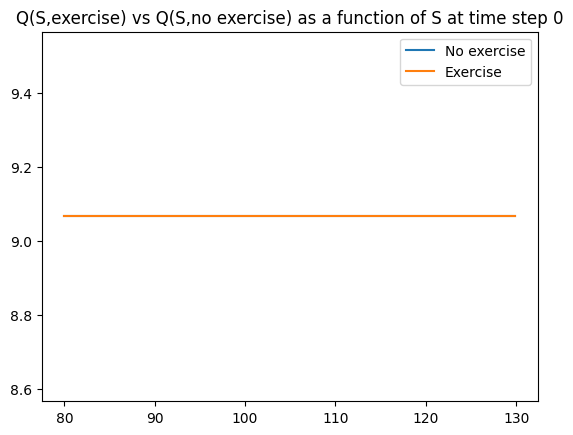

Time 1


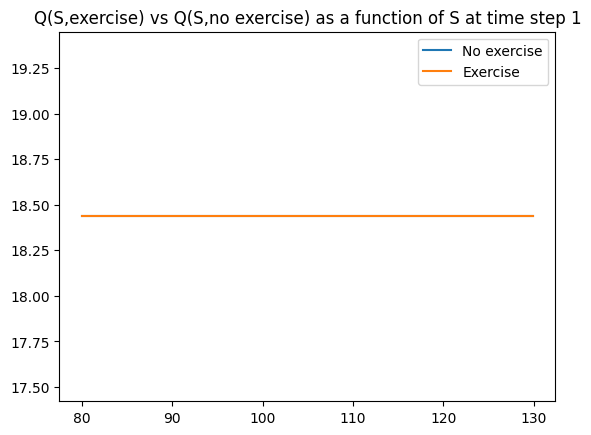

Time 2


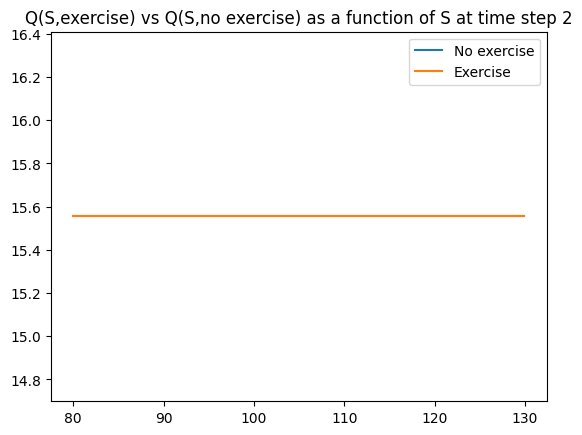

In [93]:
S_plot = np.arange(80,130,0.1)
for t,q in enumerate(result):
    print(f"Time {t:d}")
    plt.title("Q(S,exercise) vs Q(S,no exercise) as a function of S at time step "+str(t))
    plt.plot(
        S_plot,
        [q( (NonTerminal(s),0) )  for s in S_plot],
        label="No exercise"
    )
    plt.plot(
        S_plot,
        [q( (NonTerminal(s),1) )  for s in S_plot],
        label="Exercise"
    )
    plt.legend()
    plt.show()



## Question 3
We'd like to build a simple simulator of Order Book Dynamics as a
`MarkovProcess` using the code in
[rl/chapter9/order_book.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter9/order_book.py).
An object of type `OrderBook` constitutes the *State*. Your task is to
come up with a simple model for random arrivals of Market Orders and
Limit Orders based on the current contents of the `OrderBook`. This
model of random arrivals of Marker Orders and Limit Orders defines the
probabilistic transitions from the current state (`OrderBook` object) to
the next state (`OrderBook` object). Implement the probabilistic
transitions as a `MarkovProcess` and use it's `simulate` method to
complete your implementation of a simple simulator of Order Book
Dynamics.

Experiment with different models for random arrivals of Market Orders
and Limit Orders.

In [20]:
@dataclass
class MarkovProcess:
    order_book: OrderBook
    time_steps: int
    
    def simulate(self):
        print("Testing Simulate Function!")
        for step in range(self.time_steps):
            shares = random.randint(1, 100)
            
            # market order
            if random.random() < 0.5:
                # buy
                if random.random() < 0.5:
                    ob = self.order_book.buy_market_order(shares)[1]
                # sell
                else:
                    ob = self.order_book.sell_market_order(shares)[1]
            # limit order
            else:
                price = random.uniform(self.order_book.bid_price(), self.order_book.ask_price())
                # buy
                if random.random() < 0.5:
                    ob = self.order_book.buy_limit_order(price, shares)[1]
                # sell
                else:
                    ob = self.order_book.sell_limit_order(price, shares)[1]
            self.order_book = ob
        
        print("Displaying Order Book!")
        self.order_book.display_order_book()

Testing Simulate Function!
Displaying Order Book!


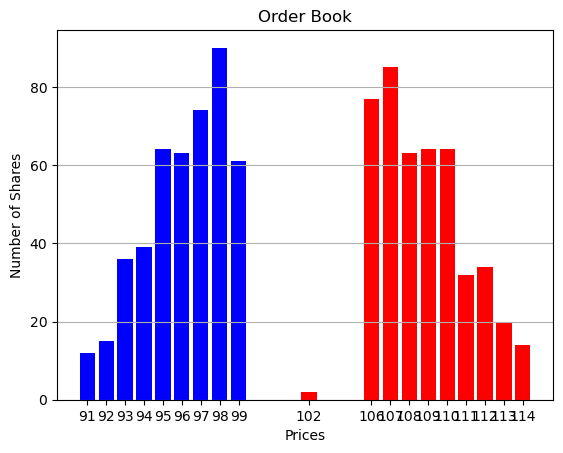


Bids
[DollarsAndShares(dollars=100, shares=104),
 DollarsAndShares(dollars=99, shares=73),
 DollarsAndShares(dollars=98, shares=90),
 DollarsAndShares(dollars=97, shares=74),
 DollarsAndShares(dollars=96, shares=63),
 DollarsAndShares(dollars=95, shares=64),
 DollarsAndShares(dollars=94, shares=39),
 DollarsAndShares(dollars=93, shares=36),
 DollarsAndShares(dollars=92, shares=15),
 DollarsAndShares(dollars=91, shares=12)]

Asks

[DollarsAndShares(dollars=105, shares=124),
 DollarsAndShares(dollars=106, shares=84),
 DollarsAndShares(dollars=107, shares=85),
 DollarsAndShares(dollars=108, shares=63),
 DollarsAndShares(dollars=109, shares=64),
 DollarsAndShares(dollars=110, shares=64),
 DollarsAndShares(dollars=111, shares=32),
 DollarsAndShares(dollars=112, shares=34),
 DollarsAndShares(dollars=113, shares=20),
 DollarsAndShares(dollars=114, shares=14)]



In [22]:
bids: PriceSizePairs = [DollarsAndShares(
    dollars=x,
    shares=poisson(100. - (100 - x) * 10)
) for x in range(100, 90, -1)]
asks: PriceSizePairs = [DollarsAndShares(
    dollars=x,
    shares=poisson(100. - (x - 105) * 10)
) for x in range(105, 115, 1)]
ob0: OrderBook = OrderBook(descending_bids=bids, ascending_asks=asks)
markov_process = MarkovProcess(order_book=ob0, time_steps=10)
markov_process.simulate()
ob0.pretty_print_order_book()

Sell Limit Order of (107, 40)

Sales Proceeds = 0.00, Shares Sold = 0

Bids
[DollarsAndShares(dollars=100, shares=104),
 DollarsAndShares(dollars=99, shares=73),
 DollarsAndShares(dollars=98, shares=90),
 DollarsAndShares(dollars=97, shares=74),
 DollarsAndShares(dollars=96, shares=63),
 DollarsAndShares(dollars=95, shares=64),
 DollarsAndShares(dollars=94, shares=39),
 DollarsAndShares(dollars=93, shares=36),
 DollarsAndShares(dollars=92, shares=15),
 DollarsAndShares(dollars=91, shares=12)]

Asks

[DollarsAndShares(dollars=105, shares=124),
 DollarsAndShares(dollars=106, shares=84),
 DollarsAndShares(dollars=107, shares=125),
 DollarsAndShares(dollars=108, shares=63),
 DollarsAndShares(dollars=109, shares=64),
 DollarsAndShares(dollars=110, shares=64),
 DollarsAndShares(dollars=111, shares=32),
 DollarsAndShares(dollars=112, shares=34),
 DollarsAndShares(dollars=113, shares=20),
 DollarsAndShares(dollars=114, shares=14)]



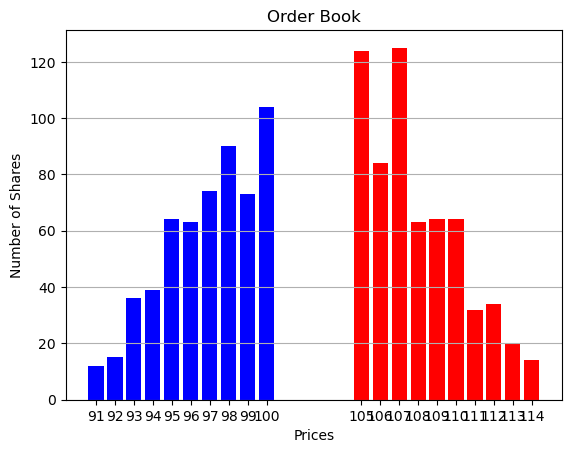

In [23]:
print("Sell Limit Order of (107, 40)")
print()
d_s1, ob1 = ob0.sell_limit_order(107, 40)
proceeds1: float = d_s1.dollars
shares_sold1: int = d_s1.shares
print(f"Sales Proceeds = {proceeds1:.2f}, Shares Sold = {shares_sold1:d}")
ob1.pretty_print_order_book()
ob1.display_order_book()

Sell Market Order of 120

Sales Proceeds = 11984.00, Shares Sold = 120

Bids
[DollarsAndShares(dollars=99, shares=57),
 DollarsAndShares(dollars=98, shares=90),
 DollarsAndShares(dollars=97, shares=74),
 DollarsAndShares(dollars=96, shares=63),
 DollarsAndShares(dollars=95, shares=64),
 DollarsAndShares(dollars=94, shares=39),
 DollarsAndShares(dollars=93, shares=36),
 DollarsAndShares(dollars=92, shares=15),
 DollarsAndShares(dollars=91, shares=12)]

Asks

[DollarsAndShares(dollars=105, shares=124),
 DollarsAndShares(dollars=106, shares=84),
 DollarsAndShares(dollars=107, shares=125),
 DollarsAndShares(dollars=108, shares=63),
 DollarsAndShares(dollars=109, shares=64),
 DollarsAndShares(dollars=110, shares=64),
 DollarsAndShares(dollars=111, shares=32),
 DollarsAndShares(dollars=112, shares=34),
 DollarsAndShares(dollars=113, shares=20),
 DollarsAndShares(dollars=114, shares=14)]



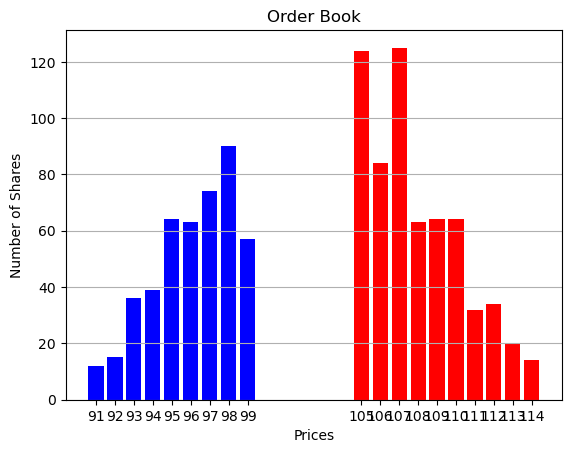

In [24]:
print("Sell Market Order of 120")
print()
d_s2, ob2 = ob1.sell_market_order(120)
proceeds2: float = d_s2.dollars
shares_sold2: int = d_s2.shares
print(f"Sales Proceeds = {proceeds2:.2f}, Shares Sold = {shares_sold2:d}")
ob2.pretty_print_order_book()
ob2.display_order_book()

Buy Limit Order of (100, 80)

Purchase Bill = 0.00, Shares Bought = 0

Bids
[DollarsAndShares(dollars=100, shares=80),
 DollarsAndShares(dollars=99, shares=57),
 DollarsAndShares(dollars=98, shares=90),
 DollarsAndShares(dollars=97, shares=74),
 DollarsAndShares(dollars=96, shares=63),
 DollarsAndShares(dollars=95, shares=64),
 DollarsAndShares(dollars=94, shares=39),
 DollarsAndShares(dollars=93, shares=36),
 DollarsAndShares(dollars=92, shares=15),
 DollarsAndShares(dollars=91, shares=12)]

Asks

[DollarsAndShares(dollars=105, shares=124),
 DollarsAndShares(dollars=106, shares=84),
 DollarsAndShares(dollars=107, shares=125),
 DollarsAndShares(dollars=108, shares=63),
 DollarsAndShares(dollars=109, shares=64),
 DollarsAndShares(dollars=110, shares=64),
 DollarsAndShares(dollars=111, shares=32),
 DollarsAndShares(dollars=112, shares=34),
 DollarsAndShares(dollars=113, shares=20),
 DollarsAndShares(dollars=114, shares=14)]



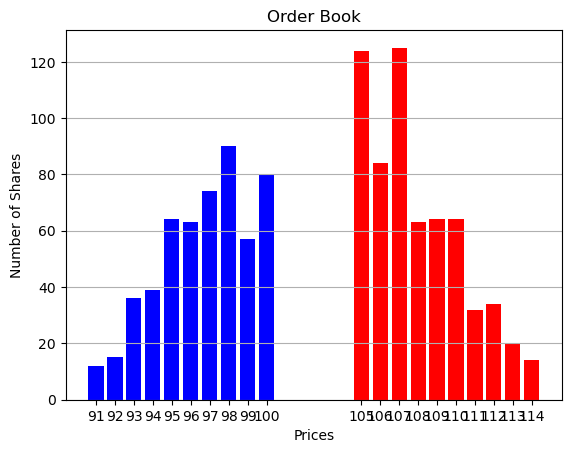

In [25]:
print("Buy Limit Order of (100, 80)")
print()
d_s3, ob3 = ob2.buy_limit_order(100, 80)
bill3: float = d_s3.dollars
shares_bought3: int = d_s3.shares
print(f"Purchase Bill = {bill3:.2f}, Shares Bought = {shares_bought3:d}")
ob3.pretty_print_order_book()
ob3.display_order_book()

Sell Limit Order of (104, 60)

Sales Proceeds = 0.00, Shares Sold = 0

Bids
[DollarsAndShares(dollars=100, shares=80),
 DollarsAndShares(dollars=99, shares=57),
 DollarsAndShares(dollars=98, shares=90),
 DollarsAndShares(dollars=97, shares=74),
 DollarsAndShares(dollars=96, shares=63),
 DollarsAndShares(dollars=95, shares=64),
 DollarsAndShares(dollars=94, shares=39),
 DollarsAndShares(dollars=93, shares=36),
 DollarsAndShares(dollars=92, shares=15),
 DollarsAndShares(dollars=91, shares=12)]

Asks

[DollarsAndShares(dollars=104, shares=60),
 DollarsAndShares(dollars=105, shares=124),
 DollarsAndShares(dollars=106, shares=84),
 DollarsAndShares(dollars=107, shares=125),
 DollarsAndShares(dollars=108, shares=63),
 DollarsAndShares(dollars=109, shares=64),
 DollarsAndShares(dollars=110, shares=64),
 DollarsAndShares(dollars=111, shares=32),
 DollarsAndShares(dollars=112, shares=34),
 DollarsAndShares(dollars=113, shares=20),
 DollarsAndShares(dollars=114, shares=14)]



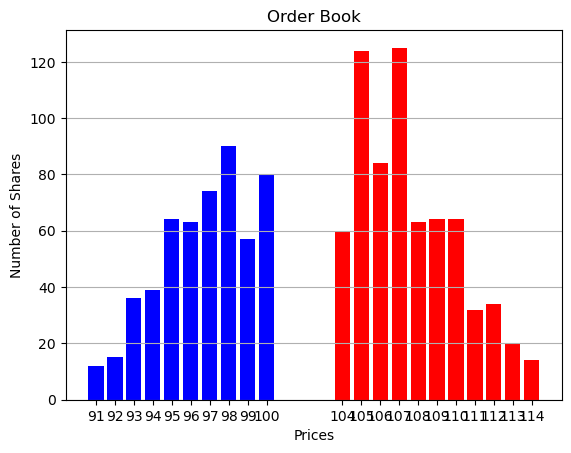

In [26]:
print("Sell Limit Order of (104, 60)")
print()
d_s4, ob4 = ob3.sell_limit_order(104, 60)
proceeds4: float = d_s4.dollars
shares_sold4: int = d_s4.shares
print(f"Sales Proceeds = {proceeds4:.2f}, Shares Sold = {shares_sold4:d}")
ob4.pretty_print_order_book()
ob4.display_order_book()

Buy Market Order of 150

Purchase Bill = 15690.00, Shares Bought = 150

Bids
[DollarsAndShares(dollars=100, shares=80),
 DollarsAndShares(dollars=99, shares=57),
 DollarsAndShares(dollars=98, shares=90),
 DollarsAndShares(dollars=97, shares=74),
 DollarsAndShares(dollars=96, shares=63),
 DollarsAndShares(dollars=95, shares=64),
 DollarsAndShares(dollars=94, shares=39),
 DollarsAndShares(dollars=93, shares=36),
 DollarsAndShares(dollars=92, shares=15),
 DollarsAndShares(dollars=91, shares=12)]

Asks

[DollarsAndShares(dollars=105, shares=34),
 DollarsAndShares(dollars=106, shares=84),
 DollarsAndShares(dollars=107, shares=125),
 DollarsAndShares(dollars=108, shares=63),
 DollarsAndShares(dollars=109, shares=64),
 DollarsAndShares(dollars=110, shares=64),
 DollarsAndShares(dollars=111, shares=32),
 DollarsAndShares(dollars=112, shares=34),
 DollarsAndShares(dollars=113, shares=20),
 DollarsAndShares(dollars=114, shares=14)]



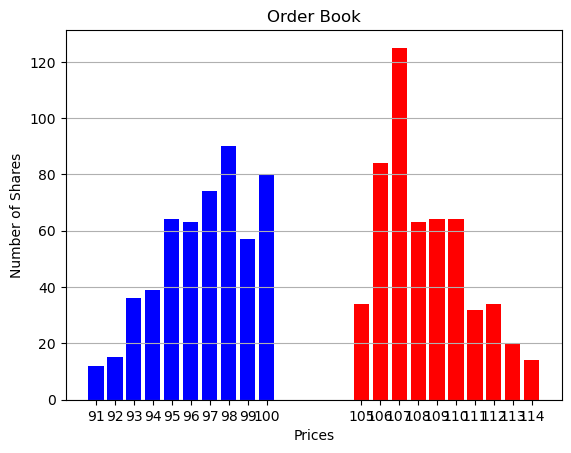

In [27]:
print("Buy Market Order of 150")
print()
d_s5, ob5 = ob4.buy_market_order(150)
bill5: float = d_s5.dollars
shares_bought5: int = d_s5.shares
print(f"Purchase Bill = {bill5:.2f}, Shares Bought = {shares_bought5:d}")
ob5.pretty_print_order_book()
ob5.display_order_book()

## Question 4
Derive the expressions for the Optimal Value Function and Optimal Policy
for the *Linear-Percentage Temporary* (LPT) Price Impact Model
formulated by Bertsimas and Lo. The LPT model is described below for all
$t = 0, 1, \ldots T-1$:

$$P_{t+1} = P_t \cdot e^{Z_t}$$ 

$$X_{t+1} = \rho \cdot X_t + \eta_t$$

$$Q_t = P_t \cdot (1 - \beta \cdot N_t - \theta \cdot X_t)$$ 

where $Z_t$ are independent and identically distributed random variables with mean
$\mu_Z$ and variance $\sigma^2_Z$ for all $t = 0, 1, \ldots, T-1$,
$\eta_t$ are independent and identically distributed random variables
with mean 0 for all $t = 0, 1, \ldots, T-1$, $Z_t$ and $\eta_t$ are
independent of each other for all $t = 0, 1, \ldots, T-1$, and
$\rho, \beta, \theta$ are given constants. The model assumes no
risk-aversion (Utility function is the identity function) and so, the
objective is to maximize the Expected Total Sales Proceeds over the
finite-horizon up to time $T$ (discount factor is 1). In your
derivation, use the same methodology as we followed for the *Simple
Linear Price Impact Model with no Risk-Aversion*.

Implement this LPT model by customizing the class
`OptimalOrderExecution` in [rl/chapter9/optimal_order_execution.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter9/optimal_order_execution.py).

Compare the obtained Optimal Value Function and Optimal Policy against
the closed-form solution you derived above.